# Cross Validation
Cross validation can be used to estimte the error in an approximation. Following Hastie, let $\hat{f}$ denote an approximation of
a function $f$ built using training data 

$$\mathcal{X}_{train}=\{X_{train},Y_{train}=f(X_{train})\}$$

and let $L(Y,\hat{f}(X))$ denote a loss function use to measure errors in the approximation. Here we will use

$$L(Y,\hat{f}(X))=(Y-\hat{f}(X))^2$$

Ideally we would like to compute the prediction error over an independent test data $\mathcal{X}_{test}$, i.e.

$$Err_\mathcal{X}=\operatorname{E}_{\mathcal{X}_{test}}[L(f(\mathcal{X}_{test}),
\hat{f}(\mathcal{X}_{test},p)\mid\mathcal{X_{train}})].$$

which is the error for the specific training set $\mathcal{X}_train$.
When evaluating $f$ is expensive, however, computing an independent test set may not be possible. Instead
of using function evaluations for approximating error we could use them to futher improve the accuracy of 
the approximation. However if we do this we can not longer compute $Err_\mathcal{X}$.

Cross validation can be used to approximate the related quantity, known as the expected prediction error. 
This quantity averages over everything that is random, i.e. the training and test data.

$$Err=\operatorname{E}_\mathcal{X_{train}}[Err_\mathcal{X}]$$

The training error, which is the loss computed the training data

$$\bar{err}=\frac{1}{M}\sum_{i=1}^M L(y_i,\hat{f}(x_i))$$ is incorrectly used to estimate prediction error.
Training error decrease with model complexity. If we contsruct an interpolant of $f$ the training error will be zero
by construction, however the model will likely overfit the training data and will under estimate the prediction error.

The cross validation can be used to estimate the prediction error when gnerating an independent test set is not 
feasiable. K-folds cross validation uses all the available training data to construct the approximation. 
Speficially the data is split into K roughly sized sets. The partition is constructed randomly without replacement.
K-1 sets are used to train the approximation and the remaining
data is used to estimate the prediction error. This procedure is repeated for K times, starting by holding out 1st data set,
then holding out the second data set and so on. Once complete the K estimates of the 
prediction error are combined. 

Let $\hat{f}^{-k}$ denote the approximation trained with the kth data set removed
then the cross validation error is given by

$$CV(\hat{f})=\frac{1}{M}\sum_{i=1}^M L(y_i,\hat{f}^{-\kappa(i)}(x_i)).$$

Here $\kappa: \{1,\ldots,M\}\rightarrow \{1,\ldots,K\}$ denotes an indexing function that return the 
number of the partition to which the ith data obervation belongs.

Asymptotically cross validation is an unbiased estimate of the expected prediction error $Err$. 
The bias decreases with as the number of samples $M$ increases
Leave one out cross validation, $K=M$ and $\kappa(i)=i$ has the smallest bias for a fixed $M$, however the
variance can be large. For a given data set $\mathcal{X}_{train}$ each of the training sets will be very similar. 
Thus the estimate of $CV$ will be very dependent on $\mathcal{X}_{train}$ thus producing a lot of variability when 
$\mathcal{X}_{train}$ is varied. Setting $K=10$ will result in a smaller variance, but a larger bias for small 
number of samples $M$. Five- or tenfold cross-validation can be a good compromise between bias and variance 
-see Breiman and Spector (1992) and Kohavi (1995).



## Initialize the environment

In [2]:
%load_ext autoreload
%autoreload 2

from PyDakota.regression import *
from PyDakota.models.genz import GenzFunction
from PyDakota.approximation import *
from PyDakota.math_tools import compute_hyperbolic_indices
from multiprocessing import Pool
import time
from scipy.misc import comb
from functools import partial
#import numpy

numpy.random.seed(3)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.usetex'] = True # use latex for all text handling
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{siunitx}', r'\usepackage{amsmath}']

# to just create static png plots use 
%matplotlib inline

# to allow interactive plots use 
# %matplotlib notebook

# use jupyter nbconvert --to python <notebook_name.ipynb> to convert to python script

# if having trouble with errors like cannot import _backports go to Kernel toolbar
# and select Restart & Clear Output

## Define function we want to approximate
We will use the oscillstory frunction from the Genz integration test suite.
$$f(x)=cos\left(2\pi w_1+\sum_{i=1}^d c_i x_i\right),\quad x\in[0,1]^d$$
where we set $$w_1=0, \quad c_i=\frac{i-0.5}{d}K, \quad K=C\sum_{i=1}^d c_i, \quad C=10$$

In [3]:
num_vars = 2
variables = BoundedVariables()
ranges = define_homogeneous_ranges(num_vars, 0., 1.);
variables.set_ranges(ranges)

function = GenzFunction('oscillatory',num_vars)
function.set_coefficients(10., 'no-decay')

## Initialize the approximation
Dakota supports many approximation methods. Here we focus on how to build a total-degree multivariate polynomial approximation

$$f(x)\approx p(T(x))=p(u)=\sum_{\|\lambda\|_1\le 10} c_\lambda\phi_\lambda(u).$$ 

To define a 3rd order total degree monomial approximation run

In [4]:
# Define variable transformation T
var_transform = AffineVariableTransformation()
var_transform.set_variables(variables)

from PyDakota.univariate_polynomials import LEGENDRE_ORTHOG
basis_types = numpy.asarray([LEGENDRE_ORTHOG]*num_vars,dtype=numpy.int32)
opts = {'poly_type':PCE,'basis_types':basis_types}
approx = polynomial_approximation_factory(var_transform, opts)

degree = 10
basis_indices = compute_hyperbolic_indices(num_vars, degree, 1.)
approx.set_basis_indices(basis_indices)

## Set up the cross validation
PyDakota provides a object to solve linear systems using cross validation. 
We want to repeat cross validation many times so lets create some functions to help us do this. The function
cross_validated_solve returns the cross validation error $CV$

In [5]:
def cross_validated_solve(basis_matrix, training_function_vals,
                          regression_type, regression_opts, seed):
    regression_opts['cv-opts']['seed']=seed
    cv_solver = CrossValidatedSolver()
    cv_solver.set_linear_system_solver(regression_type)
    cv_solver.solve(basis_matrix, training_function_vals, regression_opts)
    scores = cv_solver.get_best_scores()
    solutions = cv_solver.get_final_solutions()
    return scores, solutions

def cross_validated_solve_helper(args):
    return cross_validated_solve(*args)

Now lets perform cross validation for many different training sets. We will use Python's multiprocessing.Pool function
to do the cross validation on each training data independently. Note we are not computing the approximation on each fold,
for a given data set, indendently

In [6]:
import multiprocessing
from multiprocessing import Pool
import time

num_training_samples = 2*basis_indices.shape[1]
num_folds = 10;
regression_type=SVD_LEAST_SQ_REGRESSION
function_opts = {'eval_type':'value-grad'}
cv_opts = {'num-points':num_training_samples,'num-folds':num_folds}
regression_opts = {'verbosity':0,'cv-opts':cv_opts,'store-history':True}

num_trials = 1000;
t0 = time.time()
max_eval_concurrency=10
# Using max_eval_concurrency>1 is slower than using max_eval_concurrency=1
# I think this has something to do with OMP_NUM_THREADS used by NumPy
# if want to use
# max_eval_concurrency=max(multiprocessing.cpu_count(),1)
# open tutorial with OMP_NUM_THREADS=1 jupyter notebook Polynomial Cross Validation.ipynb

pool = Pool(max_eval_concurrency)
args = []
seeds = numpy.random.permutation(numpy.arange(1,10*num_trials))[:num_trials]
for i in range(num_trials):
    training_samples = numpy.random.uniform(0,1,(num_vars,num_training_samples))
    training_function_vals = function.value(training_samples,function_opts)
    basis_matrix = approx.generate_basis_matrix(training_samples)
    args.append([basis_matrix,training_function_vals,regression_type,regression_opts,seeds[i]])
print 'that_took:', time.time()-t0
t0 = time.time()
result = numpy.asarray(pool.map(cross_validated_solve_helper,args))
print 'that_took:', time.time()-t0

that_took: 2.84949398041
that_took: 2.06364703178


Now we want to compare the cross validation error with the RMSE error for each training set. We do this by 
evaluting the approximations, computed for each training set, on a set of validation data not used for training.

In [7]:
num_validation_samples = 1000
validation_samples = numpy.random.uniform(0,1,(num_vars,num_validation_samples))
validation_vals = function.value(validation_samples,function_opts)

t0 = time.time()    
mse = []
cv_scores = []
for i in range(num_trials):
    cv_scores_i, solutions = result[i]
    cv_scores.append(cv_scores_i)
    approx.set_coefficients(solutions)
    approx_validation_vals = approx.value(validation_samples)
    mse.append(numpy.linalg.norm(approx_validation_vals-validation_vals,axis=0)**2/num_validation_samples)
mse = numpy.asarray(mse)
cv_scores = numpy.asarray(cv_scores)
print 'that_took:', time.time()-t0

that_took: 5.14975714684


Now lets plot the cross validation error $CV$ vs the $Err_\mathcal{X}$

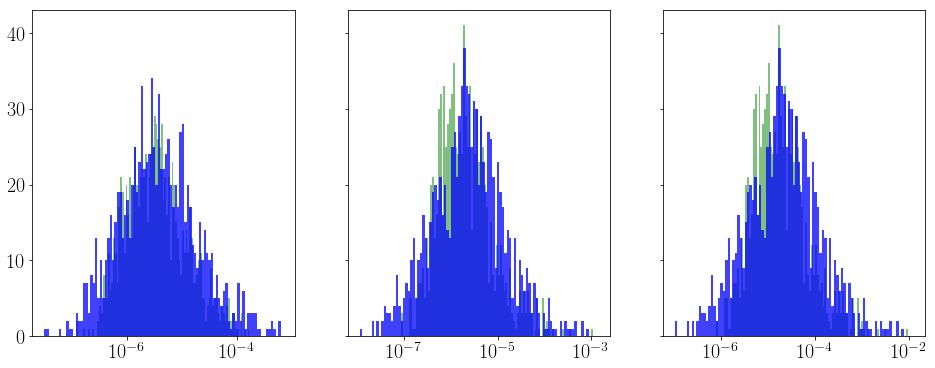

In [8]:
num_bins=100
num_rhs = mse[0].shape[0]
f,axs=plt.subplots(1,num_rhs,sharey=True,figsize=(16, 6))
axs = axs.ravel()
for j in range(num_rhs):
    bins=numpy.logspace(numpy.log10(mse[:,j].min()),numpy.log10(mse[:,j].max()), num_bins)
    n, bins, patches = axs[j].hist(mse[:,j], bins=bins, normed=None, facecolor='green', alpha=0.5,label='Err')
    bins=numpy.logspace(numpy.log10(cv_scores[:,j].min()),numpy.log10(cv_scores[:,j].max()), num_bins)
    n, bins, patches = axs[j].hist(cv_scores[:,j], bins=bins, normed=None, facecolor='blue', alpha=0.75,label='CV score')
    axs[j].set_xscale("log")